# Introduction
This is the 2021 version of the notebook created by the [Information Systems Lab](http://islab.uom.gr) to introduce students of the [University of Macedonia](http://www.uom.gr/index.php?tmima=2&categorymenu=2), Greece to Machine Learning & Data Science.

The notebook has been created to use in a RAPIDS environment. In particular in has been developed in a 16 vCPUs, GO GB RAM, and 1 NVIDIA Tesla T4 GPU in Google Cloud Platform.

## The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to **predict which previously purchased products will be in a user’s next order**.

## Objective
The objective of this notebook is to introduce students to predictive business analytics with Python through the Instacart case. 

By the time you finish this example, you will be able to:
* Describe the steps of creating a predictive analytics model
* Use Python and Pandas package to manipulate data
* Use Python and Pandas package to create, combine, and delete DataFrames
* Use Random Forests to create a predictive model
* Apply the predictive model in order to make a prediction
* Create a submission file for the competition of Instacart

## Problem definition
The data that Instacart opened up include orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as prior, train or test. Prior orders describe the **past behaviour** of a user while train and test orders regard the **future behaviour that we need to predict**. 

As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). 

For the train orders Instacart reveals the results (i.e., the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user. 

The setting of the Instacart problem is described in the figure below (orders with yellow color denotes future orders of a user). 

<img src="https://i.imgur.com/S0Miw3m.png" width="350">

Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. 

This is a **classification problem** because we need to predict whether each pair of user and product is a reorder or not. This is indicated by the value of the reordered variable, i.e. reordered=1 or reordered=0 (see figure below). 

<img src="https://i.imgur.com/SxK2gsR.png" width="350">

As a result we need to come up and calculate various **predictor variables (X)** that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

<img src="https://i.imgur.com/Yb1CKAF.png" width="600">

## Method
Our method includes the following steps:
1. <b>Import and reshape data</b>: This step includes loading CSV files into pandas DataFrames, tranform character variables to categorical variables, and create a supportive table.
2. <b>Create predictor variables</b>: This step includes identifying and calculating predictor variables (aka features) from the initial datasets provided by Instacart. 
3. <b>Create train and test DataFrames</b>: In this step we create two distinct pandas DataFrames that will be used in the creation and the use of the predictive model.
4. <b>Create predictive model (fit)</b>: In this step we train a predictive model through the train dataset.
5. <b>Apply predictive model (predict)</b>: This step includes applying the model to predict the 'reordered' variable for the test dataset.
6. <b>Create submission file</b>: In this final step we create the submission file with our predictions for Instacart's competition.
7. <b>Get F1 score</b>: In this step we submit the produced and file and get the F1 score describing the accuracy of our prediction model.

# 1. Import and Reshape Data 
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

## 1.1 Import the required packages
The **"as"** reserved word is to define an alias to the package. The alias help us to call easier a package in our code.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
matplotlib.use('Agg')
#matplotlib.style.use('ggplot')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

## 1.2 Load data from the CSV files
Instacart provides 6 CSV files, which we have to load into Python. Towards this end, we use the .read_csv() function, which is included in the Pandas package. Reading in data with the .read_csv( ) function returns a DataFrame.

We first unzip the .zip file downloaded from Kaggle.

In [2]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./input')

In [3]:
orders = pd.read_csv('input/orders.csv' )
order_products_train = pd.read_csv('input/order_products__train.csv')
order_products_prior = pd.read_csv('input/order_products__prior.csv')
products = pd.read_csv('input/products.csv')
aisles = pd.read_csv('input/aisles.csv')
departments = pd.read_csv('input/departments.csv')

This step results in the following DataFrames:
* <b>orders</b>: This table includes all orders, namely prior, train, and test. It has single primary key (<b>order_id</b>).
* <b>order_products_train</b>: This table includes training orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>order_products_prior </b>: This table includes prior orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>products</b>: This table includes all products. It has a single primary key (<b>product_id</b>)
* <b>aisles</b>: This table includes all aisles. It has a single primary key (<b>aisle_id</b>)
* <b>departments</b>: This table includes all departments. It has a single primary key (<b>department_id</b>)

We now use the .head( ) method in order to visualise the first 10 rows of these tables. Click the Output button below to see the tables.

In [16]:
#### Remove triple quotes to trim your dataset and experiment with your data
### COMMANDS FOR CODING TESTING - Get 20% of users 
orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.2, random_state=25))] 

In [17]:
orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
39,3343014,4,prior,1,6,11,NaN
40,2030307,4,prior,2,4,11,19.0
41,691089,4,prior,3,4,15,21.0
42,94891,4,prior,4,5,13,15.0
43,2557754,4,prior,5,5,13,0.0
44,329954,4,test,6,3,12,30.0
54,2565571,7,prior,1,3,9,NaN
55,2402008,7,prior,2,1,19,30.0
56,121053,7,prior,3,0,18,30.0
57,1695742,7,prior,4,2,10,9.0


In [18]:
order_products_train.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [19]:
order_products_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [20]:
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [21]:
aisles.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [22]:
departments.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


## 1.3 Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
We create a new DataFrame, named <b>op</b> which combines (merges) the DataFrames <b>orders</b> and <b>order_products_prior</b>. Bear in mind that <b>order_products_prior</b> DataFrame includes only prior orders, so the new DataFrame <b>op</b>  will contain only these observations as well. Towards this end, we use pandas' merge function with how='inner' argument, which returns records that have matching values in both DataFrames. 

In [23]:
#Merge the orders DF with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both DFs
op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,3343014,4,prior,1,6,11,NaN,36606,1,0
1,3343014,4,prior,1,6,11,NaN,7350,2,0
2,3343014,4,prior,1,6,11,NaN,35469,3,0
3,3343014,4,prior,1,6,11,NaN,2707,4,0
4,2030307,4,prior,2,4,11,19.0,42329,1,0
5,2030307,4,prior,2,4,11,19.0,7160,2,0
6,691089,4,prior,3,4,15,21.0,1200,1,0
7,691089,4,prior,3,4,15,21.0,17769,2,0
8,691089,4,prior,3,4,15,21.0,43704,3,0
9,691089,4,prior,3,4,15,21.0,37646,4,0


# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

## 2.1 Create user predictors
We create the following predictors:
- 2.1.1 Number of orders per customer
- 2.1.2 How frequent a customer has reordered products

### 2.1.1 Number of orders per customer
We calculate the total number of placed orders per customer. We create a **user** DataFrame to store the results.

In [24]:
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders').reset_index()
user.head(10)

,user_id,u_total_orders
0,4,5
1,7,20
2,10,5
3,14,13
4,18,6
5,19,9
6,22,15
7,23,4
8,24,18
9,29,18


### 2.1.2 How frequent a customer reorders products

This feature is a ratio for each user revealing how many reorders has had in their basket.
So we create the following ratio per user: **(reordered basket items)/(total basket items)**

The nominator is a counter for all the times a user has reordered products (value on reordered=1), the denominator is a counter of all the products that have been purchased on all user's orders (reordered=0 & reordered=1).

E.g., for a user that has ordered 6 products in total, where 3 times were reorders, the ratio will be:

To create the above ratio we .groupby() order_products_prior by each user and then calculate the mean of reordered.

In [25]:
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio').reset_index()
u_reorder.head(10)

,user_id,u_reordered_ratio
0,4,0.055556
1,7,0.669903
2,10,0.342657
3,14,0.323810
4,18,0.256410
5,19,0.348039
6,22,0.507246
7,23,0.100000
8,24,0.526316
9,29,0.702222


The new feature will be merged with the user DataFrame (section 2.1.1) which keep all the features based on users. We perform a left join as we want to keep all the users that we have created on the user DataFrame

In [26]:
user = user.merge(u_reorder, on='user_id', how='left')
user.head(10)

,user_id,u_total_orders,u_reordered_ratio
0,4,5,0.055556
1,7,20,0.669903
2,10,5,0.342657
3,14,13,0.323810
4,18,6,0.256410
5,19,9,0.348039
6,22,15,0.507246
7,23,4,0.100000
8,24,18,0.526316
9,29,18,0.702222


## 2.2 Create product predictors
We create the following predictors:
- 2.2.1 Number of purchases for each product
- 2.2.2 What is the probability for a product to be reordered
- 2.2.3 How many customers bought a product only once

### 2.2.1 Number of purchases for each product
We calculate the total number of purchases for each product (from all customers). We create a **prd** DataFrame to store the results.

In [27]:
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases').reset_index()
prd.head(10)

,product_id,p_total_purchases
0,1,414
1,2,18
2,3,67
3,4,54
4,6,1
5,7,8
6,8,39
7,9,43
8,10,521
9,11,34


## 2.2.2 What is the probability for a product to be reordered
In this section we want to find the products which have the highest probability of being reordered. Towards this end it is necessary to define the probability per productas below:
(number of product's reorders)/(total number of purchaces of a product) 

Example: The product with product_id=2 has been purchaced 90 times but only 12 of these are reorders.

### 2.2.2.1 Remove products with less than 40 purchases - Filter with .shape[0]
We first remove products having less than 40 purchases in order the calculated variable to be meaningful.

Using .groupby() we create groups for each product and using .filter( ) we keep only groups with more than 40 rows. Towards this end, we indicate a lambda function.

In [28]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,3343014,4,prior,1,6,11,NaN,36606,1,0
1,3343014,4,prior,1,6,11,NaN,7350,2,0
2,3343014,4,prior,1,6,11,NaN,35469,3,0
3,3343014,4,prior,1,6,11,NaN,2707,4,0
5,2030307,4,prior,2,4,11,19.0,7160,2,0
6,691089,4,prior,3,4,15,21.0,1200,1,0
7,691089,4,prior,3,4,15,21.0,17769,2,0
8,691089,4,prior,3,4,15,21.0,43704,3,0
9,691089,4,prior,3,4,15,21.0,37646,4,0
10,691089,4,prior,3,4,15,21.0,11865,5,0


### 2.2.2.2 Group products, calculate the mean of reorders

To calculate the reorder probability we will use the aggregation function mean() to the reordered column. In the reorder data frame, the reordered column indicates that a product has been reordered when the value is 1.

The .mean() calculates how many times a product has been reordered, divided by how many times has been ordered in total. 

We calculate the ratio for each product. The aggregation function is limited to column 'reordered' and it calculates the mean value of each group.

In [29]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio').reset_index()
p_reorder.head(10)

,product_id,p_reorder_ratio
0,1,0.676329
1,3,0.820896
2,4,0.425926
3,9,0.441860
4,10,0.525912
5,12,0.733333
6,23,0.460784
7,25,0.678801
8,26,0.720000
9,28,0.529801


### 2.2.2.3 Merge the new feature on prd DataFrame
The new feature will be merged with the prd DataFrame (section 2.2.1) which keep all the features based on products. We perform a left join as we want to keep all the products that we have created on the prd DataFrame.

In [30]:
prd = prd.merge(p_reorder, on='product_id', how='left')
#delete the reorder DataFrame
del p_reorder
prd.head(10)

,product_id,p_total_purchases,p_reorder_ratio
0,1,414,0.676329
1,2,18,NaN
2,3,67,0.820896
3,4,54,0.425926
4,6,1,NaN
5,7,8,NaN
6,8,39,NaN
7,9,43,0.441860
8,10,521,0.525912
9,11,34,NaN


2.2.2.4 Fill NaN values

As you may notice, there are product with NaN values. This regards the products that have been purchased less than 40 times from all users and were not included in the p_reorder DataFrame. As we performed a left join with prd DataFrame, all the rows with products that had less than 40 purchases from all users, will get a NaN value.

For these products we their NaN value with zero (0):


In [31]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head(10)

,product_id,p_total_purchases,p_reorder_ratio
0,1,414,0.676329
1,2,18,0.000000
2,3,67,0.820896
3,4,54,0.425926
4,6,1,0.000000
5,7,8,0.000000
6,8,39,0.000000
7,9,43,0.441860
8,10,521,0.525912
9,11,34,0.000000


### 2.2.3 How many customers bought a product only once

In [32]:
items= op.groupby(['product_id','user_id'])[['order_id']].count()
items.columns=['total']
items.head()

total
product_id user_id       
1          138          2
           825          1
           1598         3
           3010         1
           3904         1

In [33]:
items.drop(items[items.total > 1].index, inplace = True)
items.head()

total
product_id user_id       
1          825          1
           3010         1
           3904         1
           7275         1
           8723         1

In [34]:
items=items.groupby('product_id')[['total']].count()

In [35]:
items.columns=['customers_bought_once']
items.head()

,customers_bought_once
product_id,
1,79
2,12
3,7
4,20
6,1


In [36]:
items =items.reset_index()
items.head()

,product_id,customers_bought_once
0,1,79
1,2,12
2,3,7
3,4,20
4,6,1


In [37]:
prd=prd.merge(items, on='product_id', how='left')
prd.head()

,product_id,p_total_purchases,p_reorder_ratio,customers_bought_once
0,1,414,0.676329,79.0
1,2,18,0.000000,12.0
2,3,67,0.820896,7.0
3,4,54,0.425926,20.0
4,6,1,0.000000,1.0


## 2.3 Create user-product predictors
We create the following predictors:
- 2.3.1 How many times a user bought a product
- 2.3.2 How frequently a customer bought a product after its first purchase
- 2.3.3 How many times a customer bought a product on its last 5 orders

### 2.3.1 How many times a user bought a product
We create different groups that contain all the rows for each combination of user and product. With the aggregation function .count( ) we get how many times each user bought a product. We save the results on new **uxp** DataFrame.

In [38]:
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought').reset_index()
uxp.head(10)

,user_id,product_id,uxp_total_bought
0,4,1200,1
1,4,2707,1
2,4,7160,1
3,4,7350,1
4,4,11865,1
5,4,17769,1
6,4,19057,1
7,4,21573,1
8,4,22199,1
9,4,25146,1


### 2.3.2 How frequently a customer bought a product after its first purchase
This ratio is a metric that describes how many times a user bought a product out of how many times she had the chance to buy it (starting from her first purchase of the product): **(Times_Bought)/(Order_Range)**

* Times_Bought = Times a user bought a product
* Order_Range = Total orders placed since the first user's order of a product

For example, we examine user 1 (user_id:1) and product 13032 (product_id:13032). User 1 made 10 orders in total. She bought the product 13032 **for first time in her 2nd order** and she has bought the same product 3 times in total. The user was able to buy the product 9 times (starting from her 2nd order until her last order). As a result, she has bought it 3 out of 9 times, meaning reorder_ratio=3/9= 0,333.

The Order_Range variable is created using two supportive variables:
* Total_orders = Total number of orders of each user
* First_order_number = The order number where the customer bought a product for first time

In the next blocks we show how we create:
1. The numerator 'Times_Bought'
2. The denumerator 'Order_Range' with the use of the supportive variables 'Total_orders' & 'First_order_number' 
3. Our final ratio 'uxp_ratio'

### 2.3.2.1 Calculate the numerator ('Times_Bought')

To answer this question we .groupby( ) user_id & product_id and we count the instances of order_id for each group.

In [39]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought']
times.head()

Times_Bought
user_id product_id              
4       1200                   1
        2707                   1
        7160                   1
        7350                   1
        11865                  1

### 2.3.2.2 Calculate the denumerator ('Order_Range')
To calculate the denumerator, we first calculate the total orders of each user & first order number for each user and every product purchase.

In order to calculate the total number of orders of each cutomer ('total_orders') we .groupby( ) only by the user_id, we keep the column order_number and we get its highest value with the aggregation function .mean()

In [40]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
4,5
7,20
10,5
14,13
18,6


In order to identify the order number where the user bought a product for first time ('first_order_number') we .groupby( ) both user_id & product_id and from the order_number column we retrieve the **.min( ) value**.

In [41]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number').reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,4,1200,3
1,4,2707,1
2,4,7160,2
3,4,7350,1
4,4,11865,3


We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product, we perform a right join.

The denominator ('Order_Range') now can be created with simple operations between the columns of span DataFrame:

In [42]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span['Order_Range'] = span.total_orders - span.first_order_number + 1
# Remove the two unneeded columns
span = span.drop(columns=['total_orders', 'first_order_number'])
span.head()

,user_id,product_id,Order_Range
0,4,1200,3
1,4,2707,5
2,4,7160,4
3,4,7350,5
4,4,11865,3


### 2.3.2.3 Create the final ratio "uxp_ratio"

We merge **times** DataFrame, which contains the numerator, and **span** DataFrame, which contains the denumerator of our desired ratio. **As both variables derived from the combination of users & products, any type of join will keep all the combinations.**

We divide the Times_Bought by the Order_Range for each user and product.

In [43]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio['uxp_ratio'] = uxp_ratio.Times_Bought / uxp_ratio.Order_Range
uxp_ratio.head()

,user_id,product_id,Times_Bought,Order_Range,uxp_ratio
0,4,1200,1,3,0.333333
1,4,2707,1,5,0.200000
2,4,7160,1,4,0.250000
3,4,7350,1,5,0.200000
4,4,11865,1,3,0.333333


We select to keep only the 'user_id', 'product_id' and the final feature 'uxp_reorder_ratio'

In [44]:
uxp_ratio = uxp_ratio.drop(columns=['Times_Bought', 'Order_Range'])
uxp_ratio.head()

,user_id,product_id,uxp_ratio
0,4,1200,0.333333
1,4,2707,0.200000
2,4,7160,0.250000
3,4,7350,0.200000
4,4,11865,0.333333


In [45]:
#Remove temporary DataFrames
del [times, first_order_no, span]

### 2.3.2.4 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

In [46]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_ratio
0,4,1200,1,0.333333
1,4,2707,1,0.200000
2,4,7160,1,0.250000
3,4,7350,1,0.200000
4,4,11865,1,0.333333


### 2.3.3 How many times a customer bought a product on its last 5 orders
For this feature, we keep the last five orders of each customer and we calculate how many times they bought a product. To achieve this we need to:
* Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
* Keep only the last five orders for each order
* Perform a .groupby( ) on users and products to get how many times each customer bought a product.

Our goal is to create a new column ('order_number_back') which indicates the last order as first, the second from the end as second and so on. To achieve this, we get the highest order_number (max) for user_id==1 and we subtract the order_number of each order from it. 

Towards this end, we .groupby( ) op by the user_id and we select the column order_number. With .transform(max) we request to get the highest number of the column order_number for each group & with minus (-) op.order_number we substract the order_number of each row. Finally we add 1.

In [47]:
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,3343014,4,prior,1,6,11,NaN,36606,1,0,5
1,3343014,4,prior,1,6,11,NaN,7350,2,0,5
2,3343014,4,prior,1,6,11,NaN,35469,3,0,5
3,3343014,4,prior,1,6,11,NaN,2707,4,0,5
4,2030307,4,prior,2,4,11,19.0,42329,1,0,4
5,2030307,4,prior,2,4,11,19.0,7160,2,0,4
6,691089,4,prior,3,4,15,21.0,1200,1,0,3
7,691089,4,prior,3,4,15,21.0,17769,2,0,3
8,691089,4,prior,3,4,15,21.0,43704,3,0,3
9,691089,4,prior,3,4,15,21.0,37646,4,0,3


With the use of order_number_back we can now select to keep only the last five orders of each customer:

In [48]:
op5 = op[op.order_number_back <= 5]
op5.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,3343014,4,prior,1,6,11,NaN,36606,1,0,5
1,3343014,4,prior,1,6,11,NaN,7350,2,0,5
2,3343014,4,prior,1,6,11,NaN,35469,3,0,5
3,3343014,4,prior,1,6,11,NaN,2707,4,0,5
4,2030307,4,prior,2,4,11,19.0,42329,1,0,4
5,2030307,4,prior,2,4,11,19.0,7160,2,0,4
6,691089,4,prior,3,4,15,21.0,1200,1,0,3
7,691089,4,prior,3,4,15,21.0,17769,2,0,3
8,691089,4,prior,3,4,15,21.0,43704,3,0,3
9,691089,4,prior,3,4,15,21.0,37646,4,0,3


Having kept the last 5 orders for each user, we perform a .groupby( ) on user_id & product_id. With .count( ) we get how many times each customer bought a product.

In [49]:
last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']
last_five.head(10)

times_last5
user_id product_id             
4       1200                  1
        2707                  1
        7160                  1
        7350                  1
        11865                 1
        17769                 1
        19057                 1
        21573                 1
        22199                 1
        25146                 1

#### 2.3.3.5 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

In [50]:
uxp = uxp.merge(last_five, on=['user_id', 'product_id'], how='left')

del [op5 , last_five]
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_ratio,times_last5
0,4,1200,1,0.333333,1.0
1,4,2707,1,0.200000,1.0
2,4,7160,1,0.250000,1.0
3,4,7350,1,0.200000,1.0
4,4,11865,1,0.333333,1.0


#### 2.3.3.6 Fill NaN values
The uxp DataFrame has NaN values for our new feature. This happens as there might be products that the customer did not buy on its last five orders. For these cases, we turn NaN values into zero (0) with .fillna(0) method.

In [51]:
uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_ratio,times_last5
0,4,1200,1,0.333333,1.0
1,4,2707,1,0.200000,1.0
2,4,7160,1,0.250000,1.0
3,4,7350,1,0.200000,1.0
4,4,11865,1,0.333333,1.0


## 2.4 Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the **uxp** DataFrame and we will add the user and prd DataFrames. We do so because we want our final DataFrame (which will be called **data**) to have the following structure: 

<img style="float: left;" src="https://i.imgur.com/mI5BbFE.jpg" >


In [52]:
data = uxp.merge(user, on='user_id', how='left')
data = data.merge(prd, on='product_id', how='left')
del op, user, prd, uxp

In [53]:
data.head()

,user_id,product_id,uxp_total_bought,uxp_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,customers_bought_once
0,4,1200,1,0.333333,1.0,5,0.055556,143,0.405594,62.0
1,4,2707,1,0.200000,1.0,5,0.055556,519,0.379576,204.0
2,4,7160,1,0.250000,1.0,5,0.055556,45,0.377778,20.0
3,4,7350,1,0.200000,1.0,5,0.055556,647,0.754250,69.0
4,4,11865,1,0.333333,1.0,5,0.055556,406,0.524631,117.0


# 3. Create train and test DataFrames
## 3.1 Include information about the last order of each user

The **data** DataFrame that we have created should include two more columns which define the type of user (train or test) and the order_id of the future order.
This information can be found on the **orders** DataFrame: 

<img style="float: left;" src="https://i.imgur.com/jbatzRY.jpg" >


Towards this end:
1. We select the **orders** DataFrame to keep only the future orders (labeled as "train" & "test). 
2. Keep only the columns of our desire ['eval_set', 'order_id'] <span style="color:red">**AND** </span> 'user_id' as is the matching key with our **data** DataFrame
2. Merge **data** DataFrame with the information for the future order of each customer using as matching key the 'user_id'

In [54]:
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

,user_id,eval_set,order_id
44,4,test,329954
74,7,train,525192
88,10,train,1822501
129,14,train,2316178
207,18,train,2461523
217,19,test,1735923
272,22,test,139655
277,23,train,3402036
296,24,train,965160
439,29,train,3110252


We incorporate on **data** DataFrame the information for the last order of each customer. The matching key here is the user_id and we select a left join as we want to keep all the observations from **data** DataFrame.

In [55]:
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,customers_bought_once,eval_set,order_id
0,4,1200,1,0.333333,1.0,5,0.055556,143,0.405594,62.0,test,329954
1,4,2707,1,0.200000,1.0,5,0.055556,519,0.379576,204.0,test,329954
2,4,7160,1,0.250000,1.0,5,0.055556,45,0.377778,20.0,test,329954
3,4,7350,1,0.200000,1.0,5,0.055556,647,0.754250,69.0,test,329954
4,4,11865,1,0.333333,1.0,5,0.055556,406,0.524631,117.0,test,329954
5,4,17769,1,0.333333,1.0,5,0.055556,225,0.635556,54.0,test,329954
6,4,19057,1,0.333333,1.0,5,0.055556,15438,0.764866,1482.0,test,329954
7,4,21573,1,1.000000,1.0,5,0.055556,2289,0.603757,510.0,test,329954
8,4,22199,1,0.500000,1.0,5,0.055556,3,0.000000,3.0,test,329954
9,4,25146,1,0.500000,1.0,5,0.055556,5252,0.640708,1027.0,test,329954


## 3.2 Prepare the train DataFrame
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

<img style="float: left;" src="https://i.imgur.com/PDu2vfR.jpg" >

Towards this end:
1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors

So now we filter the **data** DataFrame so to keep only the train users:

In [56]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,customers_bought_once,eval_set,order_id
17,7,274,1,0.052632,0.0,20,0.669903,441,0.301587,241.0,train,525192
18,7,519,2,0.100000,0.0,20,0.669903,208,0.701923,36.0,train,525192
19,7,4920,7,0.368421,2.0,20,0.669903,17095,0.671717,2652.0,train,525192
20,7,4945,3,0.600000,3.0,20,0.669903,1181,0.740051,123.0,train,525192
21,7,6361,5,0.250000,0.0,20,0.669903,653,0.750383,64.0,train,525192


In [57]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(10)

,user_id,product_id,uxp_total_bought,uxp_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,customers_bought_once,eval_set,order_id,reordered
0,7,274,1,0.052632,0.0,20,0.669903,441,0.301587,241.0,train,525192,NaN
1,7,519,2,0.100000,0.0,20,0.669903,208,0.701923,36.0,train,525192,NaN
2,7,4920,7,0.368421,2.0,20,0.669903,17095,0.671717,2652.0,train,525192,NaN
3,7,4945,3,0.600000,3.0,20,0.669903,1181,0.740051,123.0,train,525192,NaN
4,7,6361,5,0.250000,0.0,20,0.669903,653,0.750383,64.0,train,525192,NaN
5,7,8277,3,0.375000,1.0,20,0.669903,17196,0.741103,1755.0,train,525192,NaN
6,7,8518,3,0.157895,1.0,20,0.669903,13726,0.621958,2521.0,train,525192,NaN
7,7,9598,3,0.157895,1.0,20,0.669903,1082,0.691312,147.0,train,525192,NaN
8,7,10504,1,0.200000,1.0,20,0.669903,1551,0.484204,515.0,train,525192,NaN
9,7,10895,3,0.166667,0.0,20,0.669903,1036,0.595560,239.0,train,525192,NaN


The last columm (reordered) is the response variable (y). 
There are combinations of User X Product which they were ordered (1) in last order where other were not (NaN value).

Now we manipulate the data_train DataFrame, to bring it into a structure for Machine Learning (X1,X2,....,Xn, y):
- Fill NaN values with value zero (regards reordered rows without value = 1)
- Set as index the column(s) that describe uniquely each row (in our case "user_id" & "product_id")
- Remove columns which are not predictors (in our case: 'eval_set','order_id')

In [58]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(10)

,user_id,product_id,uxp_total_bought,uxp_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,customers_bought_once,eval_set,order_id,reordered
0,7,274,1,0.052632,0.0,20,0.669903,441,0.301587,241.0,train,525192,0.0
1,7,519,2,0.100000,0.0,20,0.669903,208,0.701923,36.0,train,525192,0.0
2,7,4920,7,0.368421,2.0,20,0.669903,17095,0.671717,2652.0,train,525192,0.0
3,7,4945,3,0.600000,3.0,20,0.669903,1181,0.740051,123.0,train,525192,0.0
4,7,6361,5,0.250000,0.0,20,0.669903,653,0.750383,64.0,train,525192,0.0
5,7,8277,3,0.375000,1.0,20,0.669903,17196,0.741103,1755.0,train,525192,0.0
6,7,8518,3,0.157895,1.0,20,0.669903,13726,0.621958,2521.0,train,525192,0.0
7,7,9598,3,0.157895,1.0,20,0.669903,1082,0.691312,147.0,train,525192,0.0
8,7,10504,1,0.200000,1.0,20,0.669903,1551,0.484204,515.0,train,525192,0.0
9,7,10895,3,0.166667,0.0,20,0.669903,1036,0.595560,239.0,train,525192,0.0


In [59]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head()

uxp_total_bought  uxp_ratio  times_last5  u_total_orders  \
user_id product_id                                                             
7       274                        1   0.052632          0.0              20   
        519                        2   0.100000          0.0              20   
        4920                       7   0.368421          2.0              20   
        4945                       3   0.600000          3.0              20   
        6361                       5   0.250000          0.0              20   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
7       274                  0.669903                441         0.301587   
        519                  0.669903                208         0.701923   
        4920                 0.669903              17095         0.671717   
        4945                 0.669903               1181         0.740051   
        6361                 0.669903                653         0.750383   

                    customers_bought_once  reordered  
user_id product_id                                    
7       274                         241.0        0.0  
        519                          36.0        0.0  
        4920                       2652.0        0.0  
        4945                        123.0        0.0  
        6361                         64.0        0.0

## 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column (as it is the label that we want to predict).
<img style="float: left;" src="https://i.imgur.com/lLJ7wpA.jpg" >
 
 To create it, we:
- Keep only the customers who are labelled as test
- Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")
- Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [60]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
#Set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
#Remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

uxp_total_bought  uxp_ratio  times_last5  u_total_orders  \
user_id product_id                                                             
4       1200                       1   0.333333          1.0               5   
        2707                       1   0.200000          1.0               5   
        7160                       1   0.250000          1.0               5   
        7350                       1   0.200000          1.0               5   
        11865                      1   0.333333          1.0               5   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
4       1200                 0.055556                143         0.405594   
        2707                 0.055556                519         0.379576   
        7160                 0.055556                 45         0.377778   
        7350                 0.055556                647         0.754250   
        11865                0.055556                406         0.524631   

                    customers_bought_once  
user_id product_id                         
4       1200                         62.0  
        2707                        204.0  
        7160                         20.0  
        7350                         69.0  
        11865                       117.0

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.


## 4.1 Train XGBoost
XGBoost stands for e**X**treme **G**radient **Boost**ing, an algorithm that is used in many winning solutions for Kaggle competitions [(ref)](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). 

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.


In [61]:
X, y = data_train.drop('reordered', axis=1), data_train.reordered

We split the datasets in train and test sets in order to ensure that the evaluation of the model is unbiased. We tune the model using the train set and then we evaluate the final model in the test set. We hold 25% of the data for the test set. 

IMPORTANT: We split Kaggle's Train Set into train (75%) and test sets (25%). 

In [62]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

We initially create and finetune the model using the train set. In order to ensure that our model will have low variance and bias we employ repeated k-fold Cross-Validation. Cross-validation (CV) is a popular strategy for algorithm selection. The main idea behind CV is to split data, once or several times, for estimating the risk of each algorithm. Part of data (the training sample) is used for training each algorithm, and the remaining part (the validation sample) is used for estimating the risk of the algorithm. We create stratified folds when performing cross-validation. This has the effect of enforcing the same distribution of classes in each fold as in the whole training dataset when performing the cross-validation evaluation.  We perform 5-fold validation, meaning that we create and evaluate 5 models in each round and the final score is the average score of these models

IMPORTANT: We employ GPU by setting: tree_method='gpu_hist', gpu_id=0

In [63]:
paramGrid = {
         "learning_rate":[0.1],
         "n_estimators":[600],
         "max_depth": [5, 6],
         "subsample": [0.8],
         "colsample_bytree": [0.6],
         "colsample_bylevel": [0.6]
            }  

model = XGBClassifier(nthread=10, tree_method='gpu_hist', gpu_id=0)

cv = StratifiedKFold()

gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2)

fit = gridsearch.fit(X_train, y_train)

print(fit.best_score_)

print(fit.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:22] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  13.9s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:30] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   8.0s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:38] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   7.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:45] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   7.9s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:53] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   7.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   9.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:11] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   9.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:20] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   9.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:30] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   9.7s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:40] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   9.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:49] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8274265337845155
{'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.8}


In [64]:
fit.score(X_test, y_test)

0.8258780778714339

In [65]:
best = fit.best_estimator_

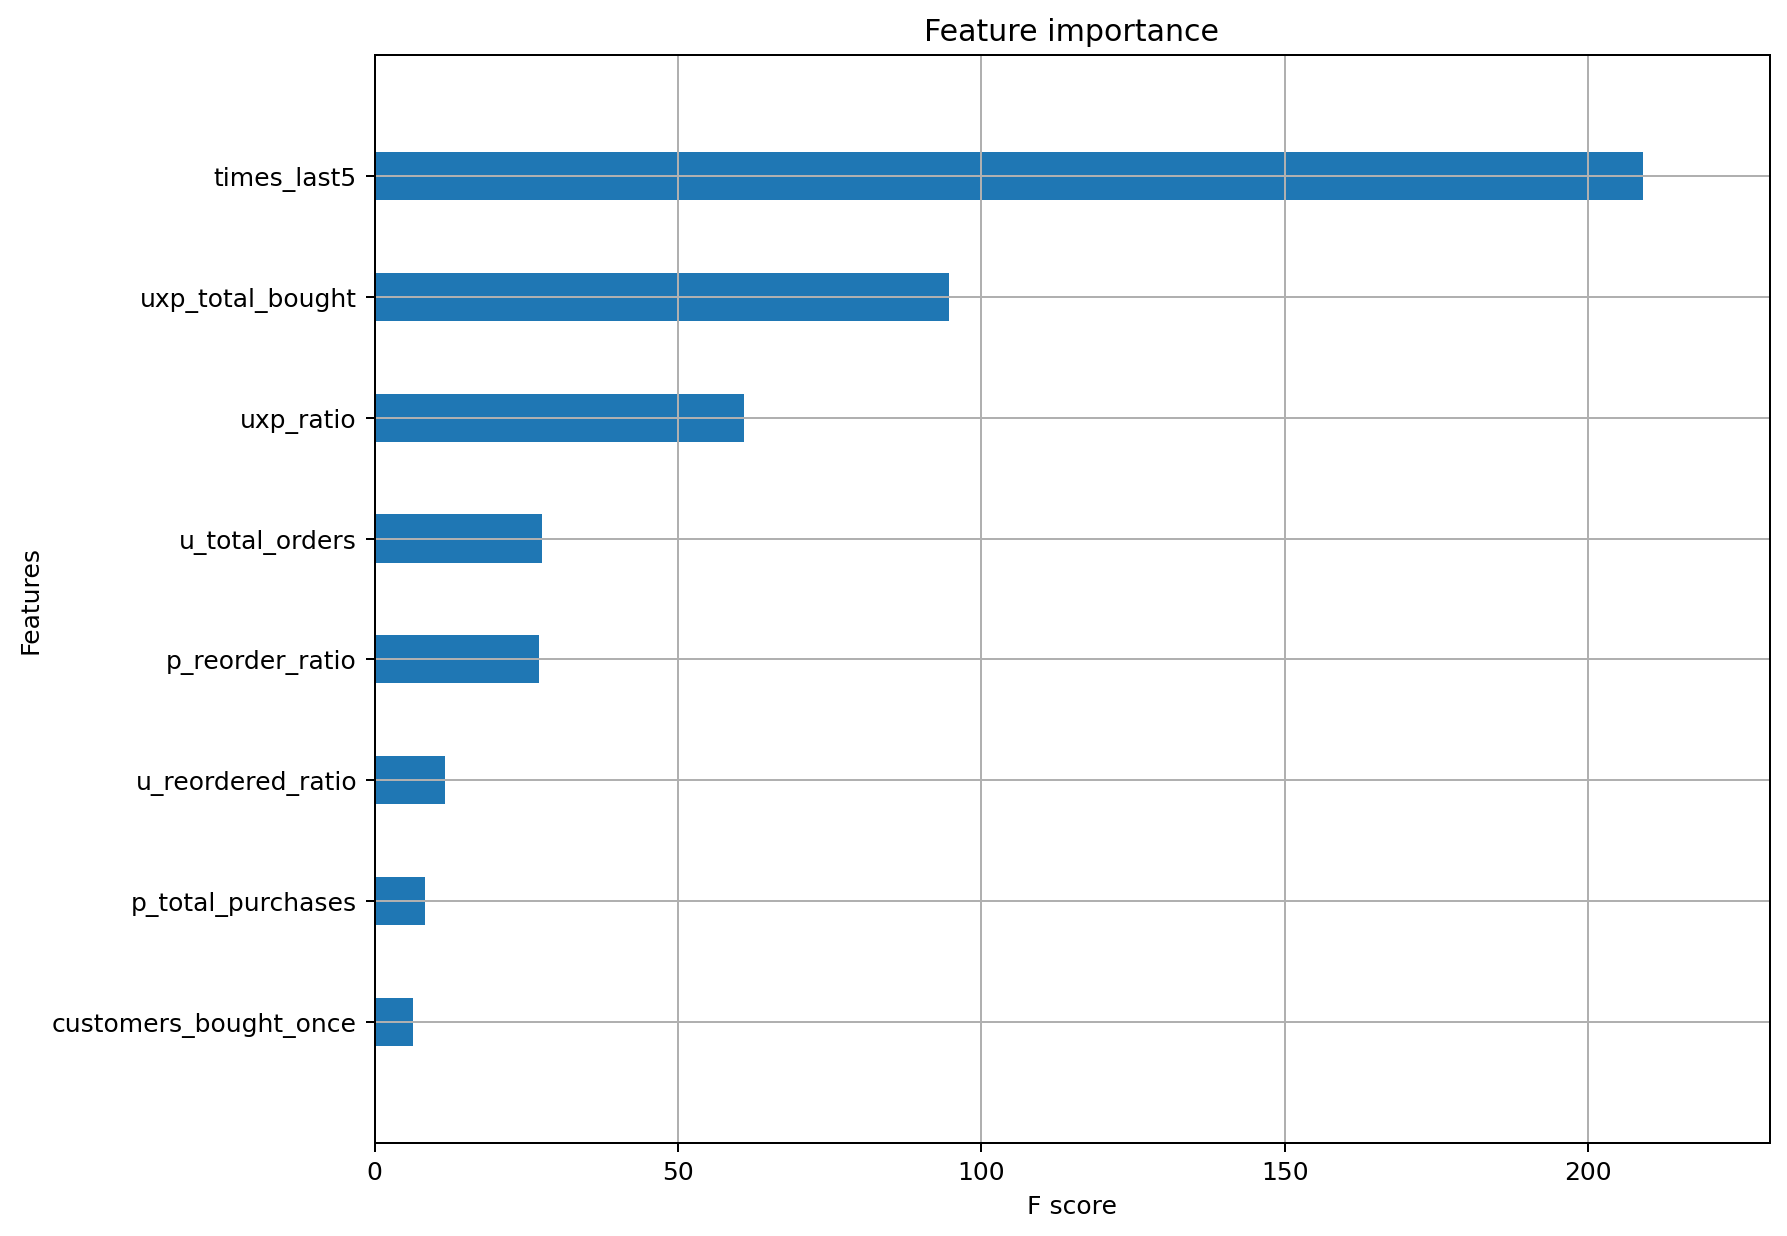

In [66]:
%matplotlib inline

fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)


plot_importance(best, height=0.4, importance_type='gain', max_num_features=30, show_values=False, ax=ax)

pyplot.show()